- Mô hình ARMA, ARIMA
- Machine Learning Methods:
    - Kalman Filters
    - Particle Filters
    - Recurrent neutral networks

## ARIMA

In [118]:
# Data
import yfinance as yf
import numpy as np
import pandas as pd

data = yf.download('AAPL', start = '2015-01-01', end = '2025-10-01',auto_adjust=False)
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2025-09-24,252.065643,252.309998,255.740005,251.039993,255.220001,42303700
2025-09-25,256.621216,256.869995,257.170013,251.710007,253.210007,55202100
2025-09-26,255.212601,255.460007,257.600006,253.779999,254.100006,46076300
2025-09-29,254.183594,254.429993,255.000000,253.009995,254.559998,40127700
2025-09-30,254.383408,254.630005,255.919998,253.110001,254.860001,37704300


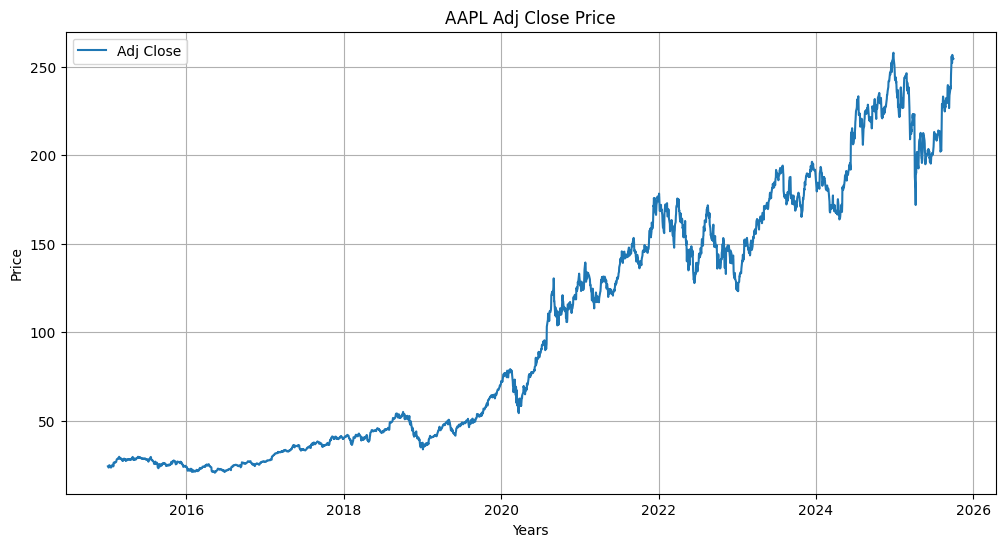

In [119]:
# Vẽ biểu đồ thể hiện Adj Close
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'],label = 'Adj Close')
plt.title('AAPL Adj Close Price')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
# Xử lý missing value
data.ffill(inplace = True)
data.dropna(inplace = True)

### ADF Test for Stationary

In [121]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    print("\n--- Biến đổi & Kiểm tra Tính dừng (ADF Test) ---")

    # 1. Chuyển sang Log Returns
    # Công thức: ln(Pt / Pt-1)
    df['Log_Ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Bỏ dòng đầu tiên bị NaN do shift
    df.dropna(inplace=True)

    # 2. Kiểm định ADF (Augmented Dickey-Fuller)
    # H0: Chuỗi không dừng (Non-stationary)
    # H1: Chuỗi có tính dừng (Stationary)
    result = adfuller(df['Log_Ret'])
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')

    if result[1] < 0.05:
        print("=> KẾT LUẬN: Dữ liệu có tính dừng (Stationary)")
    else:
        print("=> KẾT LUẬN: Dữ liệu chưa dừng. Cần lấy sai phân tiếp (Differencing).")

    return df

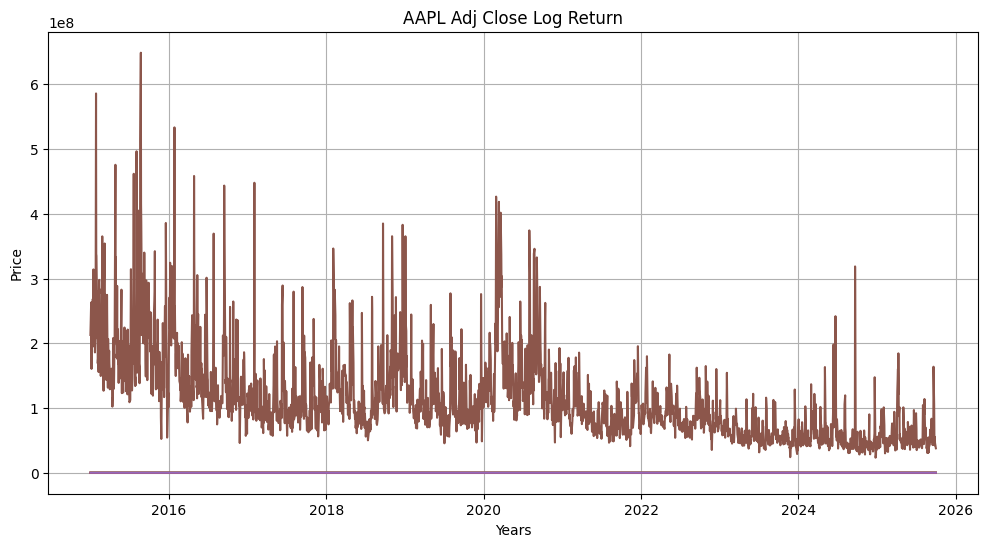

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('AAPL Adj Close Log Return')
plt.xlabel('Years')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [123]:
check_stationarity(data)


--- Biến đổi & Kiểm tra Tính dừng (ADF Test) ---
ADF Statistic: -16.7468
p-value: 0.0000
=> KẾT LUẬN: Dữ liệu có tính dừng (Stationary)


Price,Adj Close,Close,High,Low,Open,Volume,Log_Ret
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2015-01-05,23.554749,26.562500,27.162500,26.352501,27.072500,257142000,-0.028576
2015-01-06,23.556961,26.565001,26.857500,26.157499,26.635000,263188400,0.000094
2015-01-07,23.887283,26.937500,27.049999,26.674999,26.799999,160423600,0.013925
2015-01-08,24.805079,27.972500,28.037500,27.174999,27.307501,237458000,0.037702
2015-01-09,24.831682,28.002501,28.312500,27.552500,28.167500,214798000,0.001072
...,...,...,...,...,...,...,...
2025-09-24,252.065643,252.309998,255.740005,251.039993,255.220001,42303700,-0.008367
2025-09-25,256.621216,256.869995,257.170013,251.710007,253.210007,55202100,0.017912


In [124]:

# TEST SPLIT

def split_data_arima(df, target_col='Log_Ret', train_ratio=0.7):
    print(f"\n--- Chia tập Train/Test cho ARIMA model (Tỷ lệ {train_ratio*100:.0f}/{100 - train_ratio*100:.0f}) ---")

    # 1. Tính điểm cắt
    split_idx = int(len(df) * train_ratio)

    # 2. Chỉ lấy đúng cột mục tiêu (Log_Ret) để chia

    train_data = df[target_col].iloc[:split_idx].values
    test_data = df[target_col].iloc[split_idx:].values

    print(f"Tổng số ngày: {len(df)}")
    print(f"Train set: {len(train_data)} ngày")
    print(f"Test set: {len(test_data)} ngày")

    return train_data, test_data

y_train, y_test = split_data_arima(data, target_col='Log_Ret', train_ratio=0.7)

print("\n5 giá trị đầu của tập Train:", y_train[:5])


--- Chia tập Train/Test cho ARIMA model (Tỷ lệ 70/30) ---
Tổng số ngày: 2701
Train set: 1890 ngày
Test set: 811 ngày

5 giá trị đầu của tập Train: [-2.85756774e-02  9.39267301e-05  1.39248757e-02  3.77021718e-02
  1.07193543e-03]


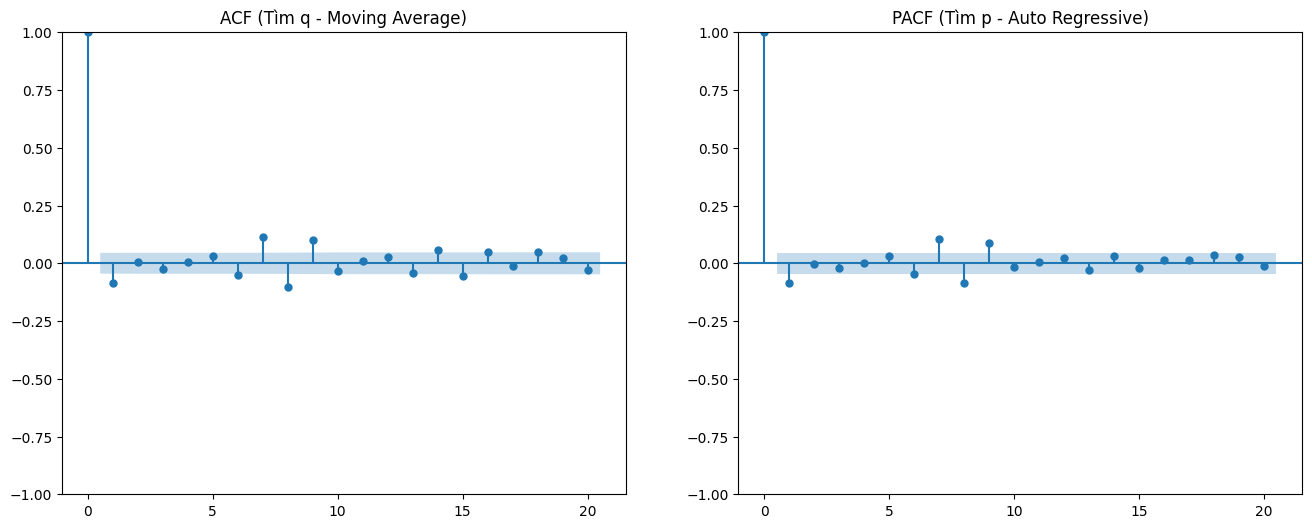

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ biểu đồ để tìm p và q
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. ACF: Giúp tìm q (MA)
plot_acf(y_train, lags=20, ax=ax1)
ax1.set_title("ACF (Tìm q - Moving Average)")

# 2. PACF: Giúp tìm p (AR)
plot_pacf(y_train, lags=20, ax=ax2)
ax2.set_title("PACF (Tìm p - Auto Regressive)")

plt.show()

Chọn ra được model ARIMA(1,0,1)

In [126]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1890
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4854.792
Date:                Sat, 06 Dec 2025   AIC                          -9701.584
Time:                        00:27:48   BIC                          -9679.406
Sample:                             0   HQIC                         -9693.417
                               - 1890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.297      0.022       0.000       0.002
ar.L1         -0.0595      0.164     -0.363      0.717      -0.381       0.262
ma.L1         -0.0266      0.168     -0.158      0.8

- ARIMA(1,0,1) có p-value c

### Kalman Filter

[*********************100%***********************]  1 of 1 completed


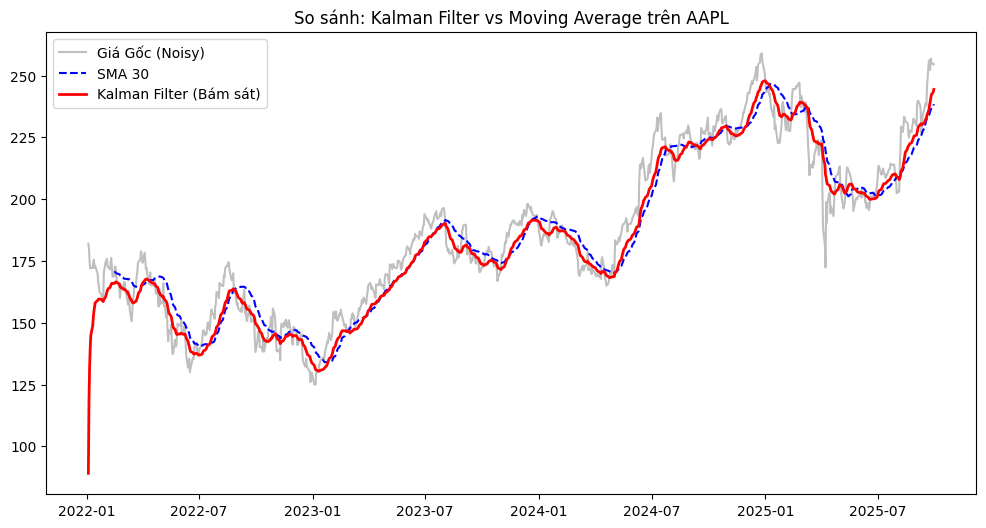

In [127]:
from pykalman import KalmanFilter


# 1. Lấy dữ liệu
data = yf.download('AAPL', start = '2022-01-01', end = '2025-10-01',auto_adjust=False)

# 2. Cấu hình Kalman Filter
# Đây là mô hình đơn giản: Giả sử giá trị tiếp theo = giá trị hiện tại (Random Walk)
# transition_covariance: Độ nhiễu của xu hướng (Process Noise)
# observation_covariance: Độ nhiễu của thị trường (Measurement Noise)
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# 3. Chạy bộ lọc
# use_smoothing=True: Dùng toàn bộ dữ liệu để làm mượt (tốt cho phân tích quá khứ)
state_means, state_covariances = kf.filter(data['Adj Close'].values)

# Lưu kết quả
data['Kalman_Price'] = state_means

# 4. So sánh với SMA (Simple Moving Average)
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Giá Gốc (Noisy)', alpha=0.5, color='gray')
plt.plot(data['SMA_30'], label='SMA 30 ', color='blue', linestyle='--')
plt.plot(data.index, data['Kalman_Price'], label='Kalman Filter (Bám sát)', color='red', linewidth=2)

plt.title(f"So sánh: Kalman Filter vs Moving Average trên AAPL")
plt.legend()
plt.show()

In [129]:
! git add .
! git commit -m "Update time series"
! git push


[main d07e104] Update time series
 1 file changed, 7 insertions(+), 9 deletions(-)


To https://github.com/tamnguyen-2905/CF_Tam22110193.git
   58d8036..d07e104  main -> main
